# Imports and Inputs

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import datetime, timedelta, timezone

from dune_client.client import DuneClient
from config import key

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/tmp/ipykernel_6293/473607918.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# import jsons of capital pool, ramm volume and covers from dune api 
dune = DuneClient(key)
cap_pool_result = dune.get_latest_result_dataframe(1442422)
ramm_volume_result = dune.get_latest_result_dataframe(3219988)
covers_list_result = dune.get_latest_result_dataframe(2303588)

# Investment Newsletter Data

In [8]:
# manually input the valuation date as a string in the format 'dd-mm-yyyy'
valn_date_str = '31-03-2024'

# manually input kiln rewards
kiln_first_round = 181.45
# create datetime object of 2023/08/30 when the Kiln validators were activated 
kiln_deposit_date = datetime(year=2023, month=8, day=30, tzinfo=timezone.utc)

# create datetime objects of 2024/04/24 and 2024/04/26 when the Kiln rewards were first claimed.
    # Note that the values for 2024/04/25 will be inaccurate
kiln_claim_start_date = datetime(year=2024, month=4, day=24, tzinfo=timezone.utc)
kiln_claim_end_date = datetime(year=2024, month=4, day=26, tzinfo=timezone.utc)
kiln_current = 0.7447

kiln_total_rewards = kiln_first_round + kiln_current

182.19469999999998

In [4]:
# create valuation datetime
valn_date = datetime.strptime(valn_date_str, '%d-%m-%Y').replace(tzinfo=timezone.utc)
# create valuation datetimes for 30 days and 365 days ago
valn_date_minus_30 = valn_date - timedelta(days=30)
valn_date_minus_365 = valn_date - timedelta(days=365)

In [5]:
# coingecko ETH API for ETH-USD at valuation date
url = 'https://api.coingecko.com/api/v3/coins/ethereum/history'
eth_price_params = {'date': valn_date_str}
eth_usd = requests.get(url, params=eth_price_params).json()['market_data']['current_price']['usd']

## Processing Capital Pool Table

In [32]:
# process capital pool table

df_cap_raw = cap_pool_result

# drop moving average columns
df_cap = df_cap_raw.drop(columns=['moving_average_eth', 'moving_average_dai', 'running_total_display_curr'])
# rename columns
df_cap.rename(columns={'running_net_eth_display_curr': 'ETH',
                   'running_net_dai_display_curr': 'DAI',
                   'running_net_rpl_display_curr': 'rETH',
                   'running_net_lido_display_curr': 'stETH',
                   'running_net_enzyme_display_curr': 'Enzyme',
                  }, inplace=True)


# turn <nil> values into 0 for rETH and turn into floats
df_cap['rETH'] = df_cap['rETH'].replace('<nil>', '0').astype('float')
# change day to a datetime
df_cap['day'] = pd.to_datetime(df_cap['day'])

# Adjust Enzyme for unclaimed Kiln returns
    # work out days since kiln deposit from the latest day and work out the rewards per day
days_first_kiln_rewards = (kiln_claim_start_date - kiln_deposit_date)/timedelta(days=1)
daily_first_kiln_rewards = kiln_first_round/days_first_kiln_rewards

days_current_kiln_rewards = (df_cap.iloc[0]['day'] - kiln_claim_end_date)/timedelta(days=1)
daily_current_kiln_rewards = kiln_current/days_current_kiln_rewards

days_total_kiln_rewards
daily_total_kiln_rewards = kiln_total_rewards / 

    # create a column for kiln rewards based on the daily values since validators went live
df_cap['kiln_rewards'] = 0
df_cap.loc[df_cap['day'] <= kiln_claim_start_date, 'kiln_rewards'] = daily_first_kiln_rewards * ((df_cap['day'] - kiln_deposit_date) / timedelta(days=1))
df_cap.loc[df_cap['day'] >= kiln_claim_end_date, 'kiln_rewards'] = daily_current_kiln_rewards * ((df_cap['day'] - kiln_claim_end_date) / timedelta(days=1))
df_cap.loc[df_cap['kiln_rewards'] < 0, 'kiln_rewards'] = 0

    # Add Kiln rewards to Enzyme column and then drop the Kiln rewards column
df_cap['Enzyme'] = df_cap['Enzyme'] + df_cap['kiln_rewards']
df_cap.drop(columns=['kiln_rewards'], inplace=True)

# add all the columns except day together to get numeric total
df_cap['sum'] = df_cap.drop(columns=['day']).sum(axis=1)

/tmp/ipykernel_6293/3673094251.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  181.45         180.68760504   179.92521008 ... -1187.81134454
 -1188.5737395  -1189.33613445]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cap.loc[df_cap['day'] <= kiln_claim_start_date, 'kiln_rewards'] = daily_first_kiln_rewards * ((df_cap['day'] - kiln_deposit_date) / timedelta(days=1))


In [33]:
df_cap

,day,ETH,DAI,rETH,stETH,Enzyme,sum
0,2024-04-30 00:00:00+00:00,26176.594891,1581.462898,14755.850620,33530.850143,13355.228183,89399.986735
1,2024-04-29 00:00:00+00:00,26248.180363,1580.091205,14753.878722,33530.850143,13355.042008,89468.042441
2,2024-04-28 00:00:00+00:00,26354.211433,1575.809269,14752.293165,33528.066976,13354.908899,89565.289742
3,2024-04-27 00:00:00+00:00,26439.018432,1584.442835,14751.901857,33525.366144,13354.775784,89655.505051
4,2024-04-26 00:00:00+00:00,26518.476112,1589.522903,14752.010901,33522.608806,13354.642676,89737.261397
5,2024-04-25 00:00:00+00:00,26639.219751,1595.101878,14753.009182,33519.801909,13236.992956,89744.125677
6,2024-04-25 00:00:00+00:00,26639.219751,1595.101878,14753.009182,33519.801909,13294.121866,89801.254587
7,2024-04-25 00:00:00+00:00,26639.219751,1595.101878,14753.009182,33519.801909,13354.695765,89861.828486
8,2024-04-24 00:00:00+00:00,26891.459484,1603.488699,14752.018318,33516.780017,13354.932995,90118.679514
9,2024-04-23 00:00:00+00:00,26926.911239,1616.138507,14751.584392,33513.346380,13354.222940,90162.203458


## Pie Chart of Assets at Valuation Date

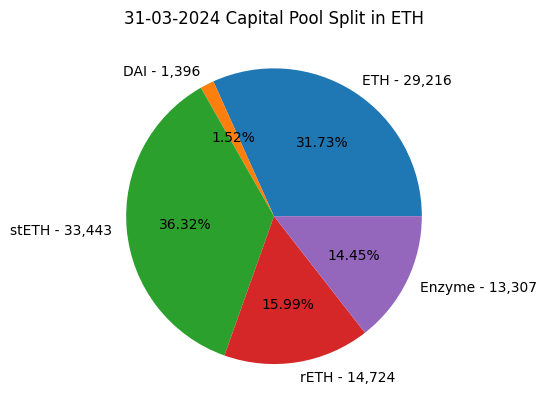

In [34]:
# pie chart of assets
asset_list = ['ETH', 'DAI', 'stETH', 'rETH', 'Enzyme']
valn_date_row = df_cap.loc[df_cap['day'] == valn_date][asset_list]

# add formatted ETH values to labels
labels = []
for n, i in enumerate(asset_list):
    formatted_value = '{:,.0f}'.format(valn_date_row.values[0][n])
    labels.append(f'{i} - {formatted_value}')

# create chart
plt.pie(valn_date_row.values[0], labels=labels, autopct='%1.2f%%')
plt.title(f'{valn_date_str} Capital Pool Split in ETH');

## 30 Day Returns on Individual Investments

In [35]:
# ETH denominated 30-day returns on individual investments

# stETH metrics in ETH
stETH_monthly_opening = df_cap.loc[df_cap['day'] == valn_date_minus_30]['stETH'].values[0]
stETH_closing = df_cap.loc[df_cap['day'] == valn_date]['stETH'].values[0]
stETH_monthly_return = stETH_closing - stETH_monthly_opening
# stETH monthly percentage
stETH_monthly_percentage = stETH_monthly_return / stETH_monthly_opening
# stETH annualised return last month
stETH_monthly_APY = ((1 + stETH_monthly_percentage) ** 12 - 1)
print(f'stETH Monthly APY: {round(stETH_monthly_APY * 100, 3)}%')
print(f'stETH Monthly Return: {round(stETH_monthly_return, 3)}')

# rETH metrics in ETH
rETH_monthly_opening = df_cap.loc[df_cap['day'] == valn_date_minus_30]['rETH'].values[0]
rETH_closing = df_cap.loc[df_cap['day'] == valn_date]['rETH'].values[0]
rETH_monthly_return = rETH_closing - rETH_monthly_opening
# rETH monthly percentage
rETH_monthly_percentage = rETH_monthly_return / rETH_monthly_opening
# rETH annualised return last month
rETH_monthly_APY = ((1 + rETH_monthly_percentage) ** 12 - 1)
print(f'rETH Monthly APY: {round(rETH_monthly_APY * 100, 3)}%')
print(f'rETH Monthly Return: {round(rETH_monthly_return, 3)}')

## Enzyme
Enzyme_fee = 0.0015
# Enzyme overall metrics in ETH
Enzyme_monthly_opening = df_cap.loc[df_cap['day'] == valn_date_minus_30]['Enzyme'].values[0]
Enzyme_closing = df_cap.loc[df_cap['day'] == valn_date]['Enzyme'].values[0]
Enzyme_monthly_return = Enzyme_closing - Enzyme_monthly_opening
# Enzyme monthly percentage
Enzyme_monthly_percentage = Enzyme_monthly_return / Enzyme_monthly_opening
# Enzyme annualised return last month
Enzyme_monthly_APY = ((1 + Enzyme_monthly_percentage) ** 12 - 1)
Enzyme_monthly_APY_after_fees = Enzyme_monthly_APY - Enzyme_fee
    
# Kiln standalone metrics in ETH
Enzyme_idle_portion = 6594 
Kiln_monthly_opening = Enzyme_monthly_opening - Enzyme_idle_portion
Kiln_closing = Enzyme_closing - Enzyme_idle_portion
Kiln_monthly_return = Kiln_closing - Kiln_monthly_opening
# Kiln monthly percentage
Kiln_monthly_percentage = Kiln_monthly_return / Kiln_monthly_opening
# Kiln annualised return last month
Kiln_monthly_APY = ((1 + Kiln_monthly_percentage) ** 12 - 1)
Kiln_monthly_APY_after_fees = Kiln_monthly_APY - Enzyme_fee

# Total ETH earned
total_monthly_inv_earnings = round(stETH_monthly_return + rETH_monthly_return + Kiln_monthly_return, 3)

print(f'Enzyme Monthly APY: {round(Enzyme_monthly_APY_after_fees * 100, 3)}%; Kiln Portion Monthly APY: {round(Kiln_monthly_APY_after_fees * 100, 3)}%')
print(f'Kiln Monthly Return: {round(Kiln_monthly_return, 3)}')

print(f'Total ETH Earned: {total_monthly_inv_earnings}')

print ('All returns after fees')

stETH Monthly APY: 3.448%
stETH Monthly Return: 94.35
rETH Monthly APY: 3.429%
rETH Monthly Return: 41.311
Enzyme Monthly APY: 1.791%; Kiln Portion Monthly APY: 3.738%
Kiln Monthly Return: 21.305
Total ETH Earned: 156.966
All returns after fees


/tmp/ipykernel_6293/583409109.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(['{:,.1%}'.format(x) for x in tick_vals])


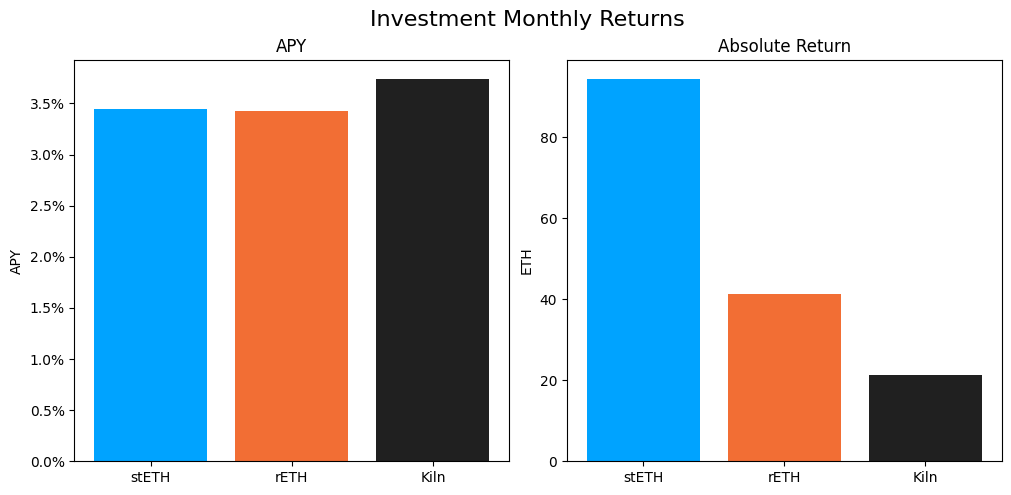

In [36]:
# MONTHLY RETURN GRAPHS FOR INDIVIDUAL INVESTMENTS

labels = ['stETH', 'rETH', 'Kiln']
colors = ['#00a3ff', '#f26e34', '#202020']

# Destructuring initialization
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle(f'Investment Monthly Returns', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

# Subplot
axs[0].bar(labels, [stETH_monthly_APY, rETH_monthly_APY, Kiln_monthly_APY_after_fees], color=colors)
axs[0].set_title('APY')
axs[0].set_ylabel('APY')
tick_vals = axs[0].get_yticks()
axs[0].set_yticklabels(['{:,.1%}'.format(x) for x in tick_vals])

# Subplot
axs[1].bar(labels, [stETH_monthly_return, rETH_monthly_return, Kiln_monthly_return*(1-0.0015)], color=colors);
axs[1].set_title('Absolute Return')
axs[1].set_ylabel('ETH')

plt.show();

In [37]:
# Total Monthly APY on the Capital Pool

# averaging the total ETH value of capital pool over the monthly period
total_cap_monthly_opening = df_cap.loc[df_cap['day'] == valn_date_minus_30]['sum'].values[0]
total_cap_monthly_closing = df_cap.loc[df_cap['day'] == valn_date]['sum'].values[0]
avg_total_cap_pool = (total_cap_monthly_closing + total_cap_monthly_opening) / 2

# monthly apy based on total earning
total_monthly_percentage = total_monthly_inv_earnings / avg_total_cap_pool
total_monthly_APY = ((1 + total_monthly_percentage) ** 12 - 1)

print(f'Total Monthly APY: {round(total_monthly_APY * 100, 3)}%')
print('Based on average Capital Pool amount over the monthly period')

Total Monthly APY: 2.031%
Based on average Capital Pool amount over the monthly period


## Monthly Changes in Capital Pool 

In [38]:
# RAMM Net Withdrawals
df_ramm = ramm_volume_result

# change timestamp to datetime format and normalise all dates to midnight
df_ramm['ts'] = pd.to_datetime(df_ramm['ts']).dt.floor('D').dt.tz_localize(timezone.utc)

# group by date, take the latest value and re-sort into descending order
df_ramm = df_ramm.groupby(by=df_ramm['ts'].dt.date, as_index=False).first().\
            sort_values(['ts'], ascending=False).reset_index(drop=True)

# determine net ramm flows 30 days before and on the valuation date by subtracting redemptions from mints
ramm_flows_monthly_opening = df_ramm.loc[df_ramm['ts'] == valn_date_minus_30]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['ts'] == valn_date_minus_30]['cummulative_eth_out'].values[0]
ramm_flows_monthly_closing = df_ramm.loc[df_ramm['ts'] == valn_date]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['ts'] == valn_date]['cummulative_eth_out'].values[0]

# determine net flows from ramm in 30 days before valuation date 
ramm_flow_monthly_change = ramm_flows_monthly_closing - ramm_flows_monthly_opening
ramm_flow_monthly_change

-3078.218273673214

In [39]:
# get net monthly change from DAI
dai_monthly_opening = df_cap.loc[df_cap['day'] == valn_date_minus_30]['DAI'].values[0]
dai_monthly_closing = df_cap.loc[df_cap['day'] == valn_date]['DAI'].values[0]
dai_change = dai_monthly_closing - dai_monthly_opening

dai_change

-115.62653681411462

In [40]:
df_covers = covers_list_result

# change timestamp to datetime format and normalise all dates to midnight
df_covers['cover_start_time'] = pd.to_datetime(df_covers['cover_start_time']).dt.floor('D')

# filter for covers that were bought on valn date and in the 30 days before
df_covers_30_days = df_covers[(df_covers['cover_start_time']>=valn_date_minus_30) & (df_covers['cover_start_time']<=valn_date)]

# filter out covers that were paid for in NXM
df_covers_30_days = df_covers_30_days[df_covers_30_days['premium_asset'] != 'NXM']

# work out cover fees denominated in ETH, allowing for 15% commission
monthly_cover_fees_usd = df_covers_30_days['premium_dollar'].sum() * 0.85
monthly_cover_fees_eth = monthly_cover_fees_usd / eth_usd
monthly_cover_fees_eth

47.50557397900421

/tmp/ipykernel_6293/2363639036.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  waterfall_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals])
/tmp/ipykernel_6293/2363639036.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
/home/rei/.pyenv/versions/3.10.6/envs/investment_monitoring/lib/python3.10/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/home/rei/.pyenv/versions/3.10.6/envs/investment_monitoring/lib/python3.10/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single eleme

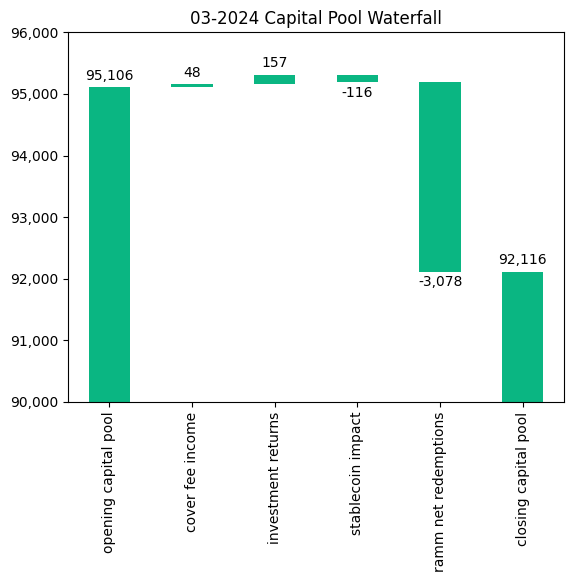

In [41]:
# waterfall chart for changes in the capital pool

# set limits on chart manually
bottom = 90_000
top = 96_000

# create dataframe with relevant categories
index = ['opening capital pool', 'cover fee income', 'investment returns', 'stablecoin impact', 'ramm net redemptions']
data = {'amount': [total_cap_monthly_opening, monthly_cover_fees_eth, total_monthly_inv_earnings, dai_change, ramm_flow_monthly_change]}
df_waterfall = pd.DataFrame(data=data, index=index)

# create a shifted dataframe by one space and fill the empty space with zero
df_shift = df_waterfall.amount.cumsum().shift(1).fillna(0)

# add the 'closing' line to both dataframes
total = df_waterfall.sum().amount
df_waterfall.loc['closing capital pool'] = total
df_shift.loc['closing capital pool'] = 0

# define the Nexus Mutual green color
color = '#0AB682'

# create waterfall plot
waterfall_plot = df_waterfall.plot.bar(stacked=True, bottom=df_shift,
                                   legend=None, color=color, title=f'{valn_date_str[-7:]} Capital Pool Waterfall')
waterfall_plot.set_ylim(bottom=bottom, top=top)

# change format of tick values
tick_vals = waterfall_plot.get_yticks()
waterfall_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals])

# label loop for individual items
maximum = df_waterfall.max()
neg_offset = maximum / 400
pos_offset = maximum / 800

y_height = df_shift

loop = 0
for index, row in df_waterfall.iterrows():
    y = y_height[loop] + row['amount']
    # determine negative or positive offset
    if row['amount'] > 0:
        y += pos_offset
    else:
        y -= neg_offset
    waterfall_plot.annotate("{:,.0f}".format(row['amount']), (loop, y), ha="center")
    loop+=1

In [17]:
# waterfall_colours = []
# cap_color = '#002332'
# pos_color = '#0AB682'
# neg_color = '#FA5050'
# waterfall_colours.append(cap_color)

# for i in df_waterfall['amount'][1:-1]:
#     if i >= 0:
#         waterfall_colours.append(pos_color)
#     else:
#         waterfall_colours.append(neg_color)

# waterfall_colours.append(cap_color)
# waterfall_colours

In [18]:
# Total change in capital pool
capital_pool_change = df_waterfall.loc['closing capital pool'].values[0] - df_waterfall.loc['opening capital pool'].values[0]
capital_pool_change

-2989.7712365083135

# Divestment Plan

## Pie Chart of Assets Today

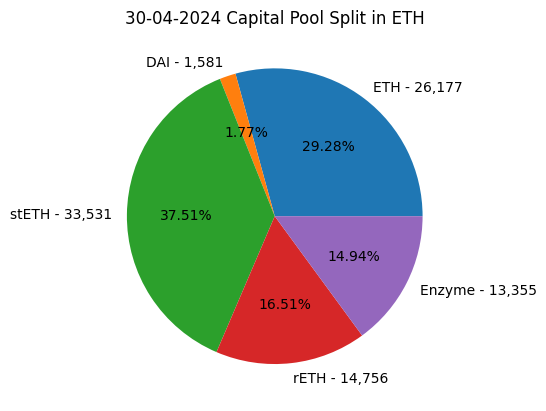

In [42]:
# pie chart of assets
asset_list = ['ETH', 'DAI', 'stETH', 'rETH', 'Enzyme']
today_row = df_cap.iloc[0][asset_list]

# add formatted ETH values to labels
labels = []
for n, i in enumerate(asset_list):
    formatted_value = '{:,.0f}'.format(today_row.values[n])
    labels.append(f'{i} - {formatted_value}')

# create chart
# extract latest date in string format
today_date_str = df_cap.iloc[0]['day'].strftime('%d-%m-%Y')
# create chart
plt.pie(today_row.values, labels=labels, autopct='%1.2f%%')
plt.title(f'{today_date_str} Capital Pool Split in ETH');

## Monthly Averages Since Start of 2024 

In [43]:
# set dates

day_today = datetime.now().day
month_today = datetime.now().month
year_today = datetime.now().year

# input start date
averages_start_date_str = '01-08-2023'
# create start datetime
averages_start_date = datetime.strptime(averages_start_date_str, '%d-%m-%Y').replace(tzinfo=timezone.utc)

In [47]:
# loop through months since the start date and obtain averages

date = averages_start_date
ramm_flows = []
net_eth_fees = []
claim_ratio = 0.7
stETH_returns = []
rETH_returns = []

while date < datetime(year_today, month_today, 1, tzinfo=timezone.utc):
    next_month = datetime(year = date.year + int(date.month / 12), month = (date.month % 12) + 1, day=date.day, tzinfo=timezone.utc)
    
    # RAMM FLOWS
    # determine net ramm flows in month in 2024
    if date.year >= 2024:
        ramm_flows_opening = df_ramm.loc[df_ramm['ts'] == date]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['ts'] == date]['cummulative_eth_out'].values[0]
        ramm_flows_closing = df_ramm.loc[df_ramm['ts'] == next_month]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['ts'] == next_month]['cummulative_eth_out'].values[0]
        ramm_flows_change = ramm_flows_closing - ramm_flows_opening
        ramm_flows.append(ramm_flows_change)
    
    # COVERS
    # filter for covers that were bought in the relevant month
    df_cover_flows = df_covers[(df_covers['cover_start_time']>=date) & (df_covers['cover_start_time']<next_month)]

    # filter for covers that were paid for in ETH
    # (note covers paid in NXM don't generate assets and covers paid for in DAI/USDC will be used to pay off the Cover Re loan)
    df_cover_flows = df_cover_flows[df_cover_flows['premium_asset'] == 'ETH']

    # work out cover fees, allowing for 15% commission
    eth_cover_fees = df_cover_flows['premium_native'].sum() * 0.85
    # append to list, allowing for 70% claim ratio
    net_eth_monthly_fees = eth_cover_fees * (1 - claim_ratio)
    net_eth_fees.append(net_eth_monthly_fees)
    
    # INVESTMENT INCOME
    # stETH
    stETH_opening = df_cap.loc[df_cap['day'] == date]['stETH'].values[0]
    stETH_closing = df_cap.loc[df_cap['day'] == next_month]['stETH'].values[0]
    stETH_returns.append(stETH_closing - stETH_opening)
    # rETH
    rETH_opening = df_cap.loc[df_cap['day'] == date]['rETH'].values[0]
    rETH_closing = df_cap.loc[df_cap['day'] == next_month]['rETH'].values[0]
    rETH_returns.append(rETH_closing - rETH_opening) 
    
    # move date along
    date = next_month

# Average Kiln rewards in month
avg_days_in_month = 30.436875
days_total_kiln_rewards = (df_cap.iloc[0]['day'] - kiln_deposit_date)/timedelta(days=1)
daily_total_kiln_rewards = kiln_total_rewards / days_total_kiln_rewards
avg_monthly_kiln_returns = daily_total_kiln_rewards * avg_days_in_month

# Average RAMM flows
avg_monthly_ramm_flows = sum(ramm_flows)/len(ramm_flows)

# Average ETH Cover Fees
avg_monthly_net_eth_fees = sum(net_eth_fees)/len(net_eth_fees)

# Average stETH returns
avg_monthly_stETH_returns = sum(stETH_returns)/len(stETH_returns)

# Average rETH returns
avg_monthly_rETH_returns = sum(rETH_returns)/len(rETH_returns)

print(f'Average monthly stETH returns = {avg_monthly_stETH_returns}')
print(f'Average monthly rETH returns = {avg_monthly_rETH_returns}')
print(f'Average monthly kiln returns = {avg_monthly_kiln_returns}')
print(f'Average monthly net ETH cover fees = {avg_monthly_net_eth_fees}')
print(f'Average monthly RAMM flows = {avg_monthly_ramm_flows}')

Average monthly stETH returns = 100.35244135042785
Average monthly rETH returns = 40.18784469357729
Average monthly kiln returns = 22.727202088370902
Average monthly net ETH cover fees = 1.2035531136837343
Average monthly RAMM flows = -3013.1837004952517


## Pie Chart of Assets After Cover Re Loan

In [57]:
today_row = df_cap.iloc[0][asset_list]

cover_re_eth = 13_942
new_idle_enzyme_eth = 6622

asset_list_new = ['ETH', 'DAI', 'stETH', 'rETH', 'Kiln', 'Enzyme Idle', 'Cover Re Loan']

today_row['Enzyme'] = today_row['Enzyme'] - new_idle_enzyme_eth
today_row['Enzyme Idle'] = new_idle_enzyme_eth
today_row.rename({'Enzyme': 'Kiln'}, inplace=True)
today_row['ETH'] = today_row['ETH'] - cover_re_eth
today_row['Cover Re Loan'] = cover_re_eth

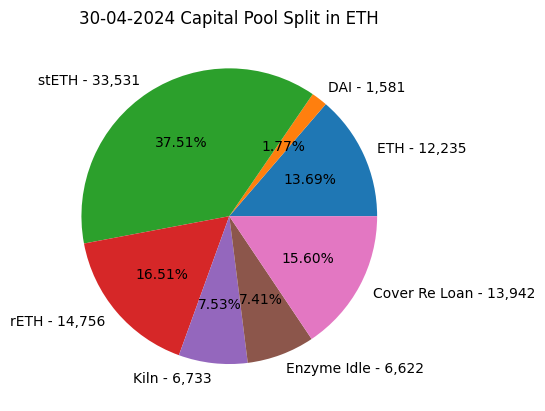

In [58]:
# add formatted ETH values to labels
labels = []
for n, i in enumerate(asset_list_new):
    formatted_value = '{:,.0f}'.format(today_row.values[n])
    labels.append(f'{i} - {formatted_value}')

# create chart
# extract latest date in string format
today_date_str = df_cap.iloc[0]['day'].strftime('%d-%m-%Y')
# create chart
plt.pie(today_row.values, labels=labels, autopct='%1.2f%%')
plt.title(f'{today_date_str} Capital Pool Split in ETH');

In [63]:
asset_df = pd.DataFrame(today_row).T

In [64]:
asset_df

,ETH,DAI,stETH,rETH,Kiln,Enzyme Idle,Cover Re Loan
0,12234.594891,1581.462898,33530.850143,14755.85062,6733.228183,6622,13942


In [69]:
asset_df['ETH'].values[-1]

12234.594891483863

In [72]:
asset_df = pd.DataFrame(today_row).T

projection_months = 12
aave_eth_apy = 0.0137

for i in range(projection_months):
    
    next_row = {}
    next_row['ETH'] = asset_df['ETH'].values[-1] + avg_monthly_ramm_flows + avg_monthly_net_eth_fees
    next_row['DAI'] = asset_df['DAI'].values[-1]
    next_row['stETH'] = asset_df['stETH'].values[-1] + avg_monthly_stETH_returns
    next_row['rETH'] = asset_df['rETH'].values[-1] + avg_monthly_rETH_returns
    next_row['Kiln'] = asset_df['Kiln'].values[-1] + avg_monthly_kiln_returns
    next_row['Enzyme Idle'] = asset_df['Enzyme Idle'].values[-1]
    next_row['Cover Re Loan'] = asset_df['Cover Re Loan'].values[-1] * ((1 + aave_eth_apy)**(1/12))
    
    asset_df.loc[len(asset_df)] = next_row

asset_df

,ETH,DAI,stETH,rETH,Kiln,Enzyme Idle,Cover Re Loan
0,12234.594891,1581.462898,33530.850143,14755.85062,6733.228183,6622,13942
1,9222.614744,1581.462898,33631.202584,14796.038464,6755.955385,6622,13957.818037
2,6210.634597,1581.462898,33731.555026,14836.226309,6778.682587,6622,13973.65402
3,3198.654449,1581.462898,33831.907467,14876.414154,6801.409789,6622,13989.50797
4,186.674302,1581.462898,33932.259908,14916.601998,6824.136991,6622,14005.379907
5,-2825.305845,1581.462898,34032.61235,14956.789843,6846.864193,6622,14021.269852
6,-5837.285993,1581.462898,34132.964791,14996.977688,6869.591395,6622,14037.177825
7,-8849.26614,1581.462898,34233.317232,15037.165533,6892.318597,6622,14053.103846
8,-11861.246288,1581.462898,34333.669674,15077.353377,6915.0458,6622,14069.047937
9,-14873.226435,1581.462898,34434.022115,15117.541222,6937.773002,6622,14085.010117
